In [1]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F
from tqdm import tqdm

class DeepFakeDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = models.resnet50(pretrained=True)
        self.cnn.fc = nn.Identity()  # Remove final FC layer
        self.rnn = nn.LSTM(input_size=2048, hidden_size=128, batch_first=True)
        self.fc = nn.Linear(128, 1)

    def forward(self, x):
        # x: (batch_size, seq_len, C, H, W)
        # print(x.shape)
        batch_size, seq_len = x.size(0), x.size(1)
        cnn_features = []
        for i in range(seq_len):
            features = self.cnn(x[:, i, :, :, :])  # (batch_size, 2048)
            cnn_features.append(features)
        cnn_features = torch.stack(cnn_features, dim=1)  # (batch_size, seq_len, 2048)
        _, (hidden, _) = self.rnn(cnn_features)
        output = self.fc(hidden[-1])
        return torch.sigmoid(output)


In [ ]:
import os
import pandas as pd
import torch
import torchvision
from torch.utils.data import Dataset
from PIL import Image


class SingleVideoDataset(Dataset):
    def __init__(self, video_folder, label, transform=None):
        """
        Args:
            video_folder (str): Path to the folder containing frames of a single video.
            label (int/str): Label for the video.
            transform (callable, optional): Optional transform to be applied on each frame.
        """
        self.video_folder = video_folder
        self.label = label
        self.frame_paths = sorted([os.path.join(video_folder, f) for f in os.listdir(video_folder)])
        self.transform = transform

    def __len__(self):
        # Return 1 because each instance is a whole video (sequence of frames)
        return 1

    def __getitem__(self, idx):
        # Load all frames in the video folder
        frames = []
        for img_path in self.frame_paths:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
            frames.append(image)
        # Stack frames into a single tensor (T, C, H, W)
        frames = torch.stack(frames, dim=0)
        return frames, self.label
    

from sklearn.model_selection import train_test_split

class AllVideosDataset(Dataset):
    def __init__(self, root_dir, metadata_path, transform=None, split='train', val_size=0.2, random_state=42):
        """
        Args:
            root_dir (str): Directory with all video folders.
            metadata_path (str): Path to the CSV file with video_id and label.
            transform (callable, optional): Optional transform to be applied on each frame.
            split (str): Either 'train' or 'val'.
            val_size (float): Proportion of data to use for validation.
            random_state (int): Random seed for reproducibility.
        """
        self.root_dir = root_dir
        self.metadata = pd.read_csv(metadata_path)
        self.transform = transform

        # Split metadata into train and val
        train_df, val_df = train_test_split(
            self.metadata, test_size=val_size, random_state=random_state
        )
        self.metadata = train_df if split == 'train' else val_df

        self.video_datasets = []
        no_data_videos = []
        for _, row in self.metadata.iterrows():
            video_id = row['video_id']
            label = row['Label']
            video_folder = os.path.join(root_dir, "images", f"{video_id}")
            if os.path.exists(video_folder) and os.listdir(video_folder):
                self.video_datasets.append(SingleVideoDataset(video_folder, label, transform))
            else:
                no_data_videos.append(video_id)
        if no_data_videos:
            print(f"Warning: No data found for {len(no_data_videos)} videos.")

    def __len__(self):
        return len(self.video_datasets)

    def __getitem__(self, idx):
        return self.video_datasets[idx][0]


In [3]:
class CollateFn:
    def __init__(self, pad_value=0, max_frames=None):
        self.pad_value = pad_value
        self.max_frames = max_frames

    def __call__(self, batch):
        frames, labels = zip(*batch)
        if self.max_frames is not None:
            frames = [f[:self.max_frames] if f.shape[0] > self.max_frames else f for f in frames]
        max_frames = max(f.shape[0] for f in frames)
        padded_frames = torch.stack([
            F.pad(f, (0, 0, 0, 0, 0, 0, 0, max_frames - f.shape[0]), value=self.pad_value)
            for f in frames
        ])
        return padded_frames, torch.tensor(labels)



In [4]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
dataset = AllVideosDataset('data', 'data/metadata.csv', transform=transform)



In [5]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=CollateFn(max_frames=8))

print(f'Total samples in dataset: {len(dataset)}')
first_batch = next(iter(dataloader))
print(first_batch[0].shape)


Total samples in dataset: 6000
torch.Size([4, 8, 3, 224, 224])


In [6]:
# training setup
model = DeepFakeDetector()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f'using device {device}')

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.BCELoss()
model.train()

num_epochs = 1
for epoch in range(num_epochs):
    # wrap dataloader with tqdm so we can update the loss as a postfix
    epoch_iter = tqdm(dataloader, desc=f'Epoch [{epoch+1}/{num_epochs}]')
    for images, labels in epoch_iter:
        optimizer.zero_grad()
        outputs = model(images.to(device))
        loss = criterion(outputs.squeeze(), labels.float().to(device))
        loss_value = loss.item()
        # show loss as a suffix/postfix on the tqdm bar instead of printing
        epoch_iter.set_postfix({'loss': f'{loss_value:.4f}'})
        loss.backward()
        optimizer.step()


c:\Users\lorra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lorra\AppData\Local\Programs\Python\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


using device cuda


Epoch [1/1]: 100%|██████████| 1500/1500 [27:58<00:00,  1.12s/it, loss=0.0345]


Predictions: [1 0 1 1], Ground Truth: [1 0 1 1]
torch.Size([4, 8, 3, 224, 224])


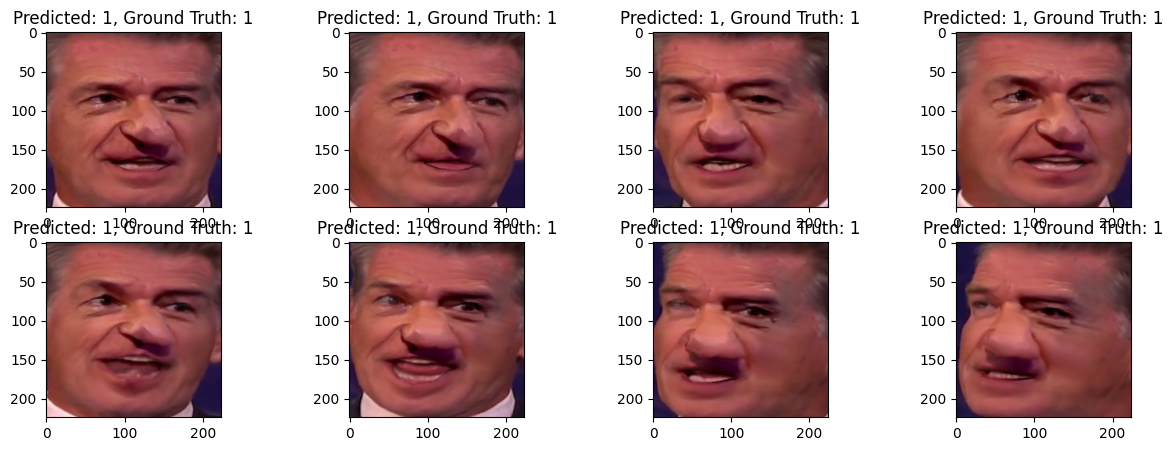

In [15]:
# inference example
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    for images, labels in dataloader:
        outputs = model(images.to(device))
        predictions = (outputs.squeeze() > 0.5).long()
        print(f'Predictions: {predictions.cpu().numpy()}, Ground Truth: {labels.numpy()}')
        print(images.shape) # (B, T, C, H, W)
        fig, ax = plt.subplots(2, images[0].shape[0] // 2, figsize=(15, 5))
        for i in range(2):
            for j in range(images[0].shape[0] // 2):
                # unnormalize and plot
                img = images[0][i * (images[0].shape[0] // 2) + j]
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                ax[i, j].imshow(img.permute(1, 2, 0).cpu())
                ax[i, j].set_title(f'Predicted: {predictions[0].item()}, Ground Truth: {labels[0].item()}')
        plt.show()
        
        break